## Data Preprocessing and Setup

In [10]:
import csv
import pandas
import cv2
import sklearn
from sklearn.utils import shuffle

log = pandas.read_csv('./data/driving_log.csv')
center = log.center.tolist()
left = log.left.tolist()
right = log.right.tolist()
steering = log.steering.tolist()

# Read image paths and steering angles from csv file
car_images_path = []
steering_angles = []
for i in center:
    index = center.index(i)
    
    correction = 0.175 # parameter to tune
    measure = float(steering[index])
    steering_left = measure + correction
    steering_right = measure - correction
    
    car_images_path.append('./data/' + center[index].strip())
    car_images_path.append('./data/' + left[index].strip())
    car_images_path.append('./data/' + right[index].strip())
    steering_angles.extend([measure, steering_left, steering_right])

    
# Randomly suffle the data set
car_images_path, steering_angles = shuffle(car_images_path, steering_angles)

# Split the data set into training/validation with ratio of 80/20
from sklearn.model_selection import train_test_split
X_train_samples, X_validation_samples, y_train_samples, y_validation_samples = train_test_split(
    car_images_path, steering_angles, test_size=0.2)


In [11]:
def generator(samples, lables, batch_size=128):
    num_samples = len(samples)
    while 1:
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_lables = lables[offset:offset+batch_size]
            
            images = []
            angles = []
            for image_path, label in zip(batch_samples, batch_lables):
                image = cv2.imread(image_path)
                steering_angle = label;
                # Data augumentation, added flip images
                images.extend([image, cv2.flip(image,1)])
                #images.extend([cv2.resize(image, (220, 66), interpolation = cv2.INTER_AREA), cv2.flip(image,1)])
                angles.extend([steering_angle, -steering_angle])
            
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

            
# Compile and train the model using the generator function
train_generator = generator(X_train_samples, y_train_samples)
validation_generator = generator(X_validation_samples, y_validation_samples)

## Data Verification

image index:  216 , image shape:  (160, 320, 3)
-0.0


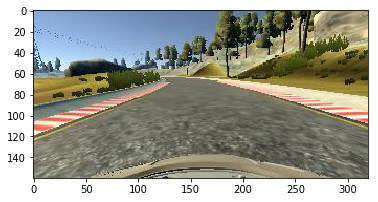

In [15]:
# Verify data have been loaded successfully through generator
X_train_verify, y_train_verify = next(train_generator)

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train_verify))
# image_array = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2BGR)
image = cv2.cvtColor(np.asarray(X_train_verify[index]), cv2.COLOR_BGR2RGB)
print('image index: ',index ,', image shape: ',image.shape)
print(y_train_verify[index])
plt.imshow(image)

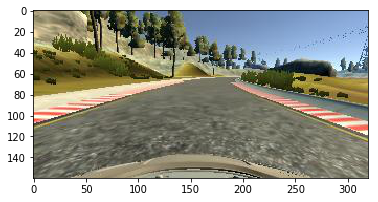

In [18]:
fliped_image = cv2.flip(image,1)
plt.imshow(fliped_image)

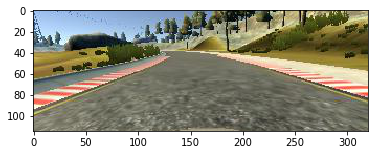

In [21]:
crop_image = image[25:140, 0:320] # Crop from x, y, w, h -> 100, 200, 300, 400
plt.imshow(crop_image)

In [8]:

print('number of training data set ', len(X_train_samples)*2)


number of training data set  51978


## Model Training Pipeline

In [392]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((75,25),(0,0))))

# Model training using a modified Nvidia CNN
# https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
# model.add(Convolution2D(24, 5, 5, activation="relu"))
# model.add(MaxPooling2D())
# model.add(Convolution2D(36, 5, 5, activation="relu"))
# model.add(MaxPooling2D())
# model.add(Convolution2D(48, 5, 5, activation="relu"))
# model.add(MaxPooling2D())
# model.add(Convolution2D(64, 3, 3, activation="relu"))
# model.add(Convolution2D(64, 3, 3, activation="relu"))

# model.add(Flatten())
# model.add(Dense(120))
# model.add(Activation('relu'))
# #model.add(Dropout(0.85)) 
# model.add(Dense(84))
# model.add(Activation('relu'))
# #model.add(Dropout(0.85))
# model.add(Dense(42))
# model.add(Activation('relu'))
# #model.add(Dropout(0.85))
# model.add(Dense(1))


# Model training using a basic LeNet CNN
model.add(Convolution2D(6,5,5, activation="relu"))
model.add(MaxPooling2D()) # Prevent overfitting
model.add(Convolution2D(16,5,5, activation="relu"))
model.add(MaxPooling2D()) # Prevent overfitting
model.add(Flatten())
model.add(Dense(120))
model.add(Activation('relu'))
model.add(Dense(84))
model.add(Activation('relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.summary()
model.fit_generator(train_generator, samples_per_epoch=len(X_train_samples)*2, 
                    validation_data=validation_generator, nb_val_samples=len(X_validation_samples)*2,
                    nb_epoch=1)

model.save('model.h5')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_61 (Lambda)               (None, 160, 320, 3)   0           lambda_input_61[0][0]            
____________________________________________________________________________________________________
cropping2d_56 (Cropping2D)       (None, 60, 320, 3)    0           lambda_61[0][0]                  
____________________________________________________________________________________________________
convolution2d_151 (Convolution2D (None, 56, 316, 6)    456         cropping2d_56[0][0]              
____________________________________________________________________________________________________
maxpooling2d_92 (MaxPooling2D)   (None, 28, 158, 6)    0           convolution2d_151[0][0]          
___________________________________________________________________________________________

KeyboardInterrupt: 